# SK5004 Pembelajaran Mesin dan Kecerdasan Buatan
## Tugas 4 (W11): Iris Species Classification

Nama    : Habiburrohman <br>
NIM     : 10121089

## 1 Library Preparation


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score,  precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## 2 Data Preparation

In [66]:
iris = datasets.load_iris()
print("Features: ", iris.feature_names)
print("Labels: ", iris.target_names)
print(iris.data.shape)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Labels:  ['setosa' 'versicolor' 'virginica']
(150, 4)


In [67]:
X = pd.DataFrame(iris.data)
y = pd.Series(iris.target, name='species').apply(lambda x: iris.target_names[x])
X = X.set_axis(iris.feature_names, axis=1)
df = pd.concat([X, y], axis=1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [68]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [69]:
def match_target(x, species):
    for s in species:
        if s in x:
            return s
        
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/iris.csv'
names = df.columns
dataset = pd.read_csv(url, names=names)
dataset['species'] = dataset['species'].apply(lambda x: match_target(x, iris.target_names))
all(dataset == df)

True

## 3 Data Preprocessing

### 3.1 Target Encoding

In [70]:
df['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [71]:
species = list(iris.target_names)

def encode_category(x, order):
    return order.index(x)

df['species'] = df['species'].apply(lambda x: encode_category(x, species))

### 3.2 Scatter Matrix

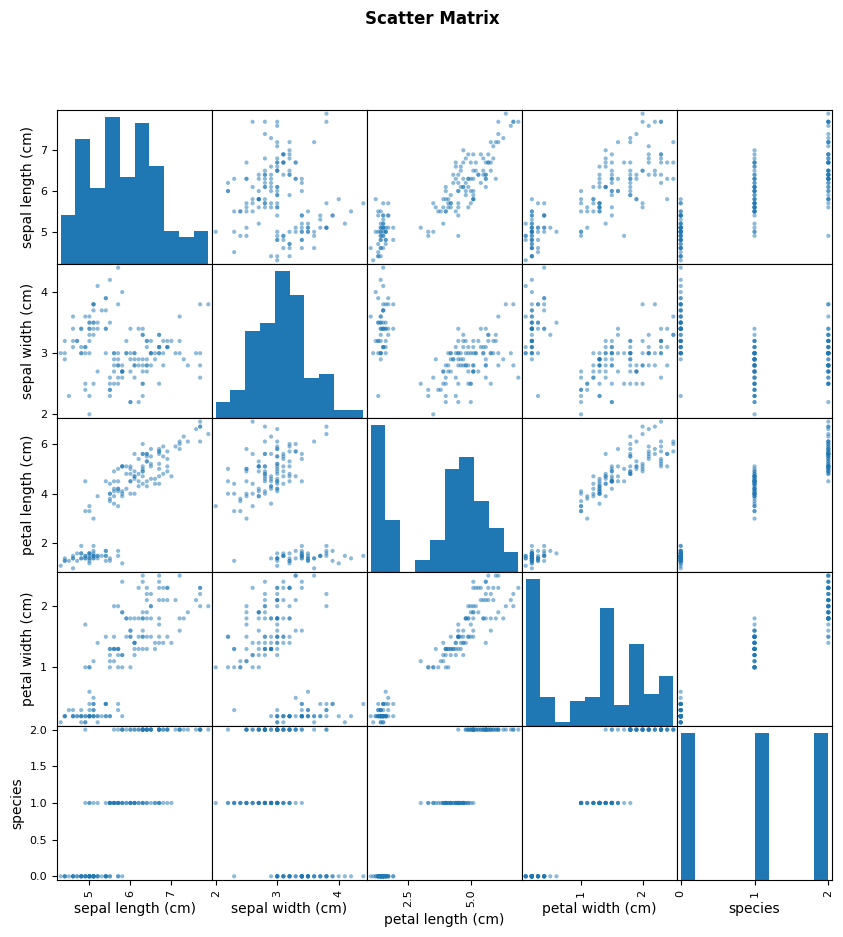

In [72]:
# fig, ax = plt.subplots()
pd.plotting.scatter_matrix(df, figsize=(10, 10))
plt.suptitle('Scatter Matrix', fontweight='bold')
# plt.tight_layout()
plt.show()

### 3.3 Correlation Matrix

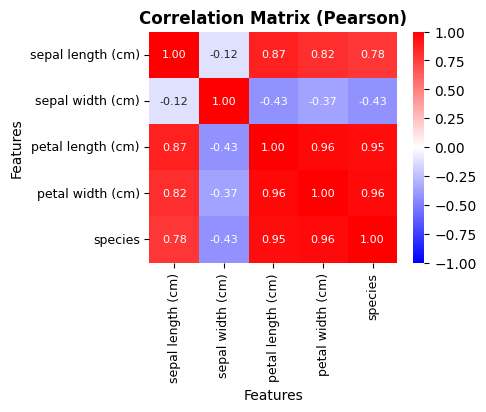

In [73]:
plt.figure(figsize=(4, 3))
ax = sns.heatmap(df.corr(numeric_only=True, method='pearson'), vmin=-1, vmax=1, cmap='bwr', annot=True, fmt='.2f', annot_kws={'fontsize': 8})
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize': 9})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize': 9})
plt.title('Correlation Matrix (Pearson)', fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

## 4 Model Building

### 4.1 Preparation

In [74]:
X = df.drop('species', axis=1, inplace=False).copy()
y = df['species'].copy()
y_decoded = y.apply(lambda x: species[x])
X_train, X_test, y_train, y_test = train_test_split(X, y_decoded,
                                                    test_size=0.2, stratify=y, 
                                                    random_state=89)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 4), (120,), (30, 4), (30,))

In [75]:
models = {
    'LR': LogisticRegression(random_state=89), 
    'LDA': LinearDiscriminantAnalysis(), 
    'KNN': KNeighborsClassifier(), 
    'CART': DecisionTreeClassifier(random_state=89), 
    'NB': GaussianNB(), 
    'SVM': SVC(random_state=89) 
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=89)

scoring = {'Accuracy': make_scorer(accuracy_score)}
for i, target in enumerate(iris.target_names):
    scoring[f'Precision_{target}'] = make_scorer(precision_score, average=None, labels=[target])
    scoring[f'Recall_{target}'] = make_scorer(recall_score, average=None, labels=[target])
    scoring[f'F1_{target}'] = make_scorer(f1_score, average=None, labels=[target])

for i, avg_mode in enumerate(['micro', 'macro', 'weighted']):
    scoring[f'Precision_{avg_mode}'] = make_scorer(precision_score, average=avg_mode)
    scoring[f'Recall_{avg_mode}'] = make_scorer(recall_score, average=avg_mode)
    scoring[f'F1_{avg_mode}'] = make_scorer(f1_score, average=avg_mode)

scoring

{'Accuracy': make_scorer(accuracy_score, response_method='predict'),
 'Precision_setosa': make_scorer(precision_score, response_method='predict', average=None, labels=[np.str_('setosa')]),
 'Recall_setosa': make_scorer(recall_score, response_method='predict', average=None, labels=[np.str_('setosa')]),
 'F1_setosa': make_scorer(f1_score, response_method='predict', average=None, labels=[np.str_('setosa')]),
 'Precision_versicolor': make_scorer(precision_score, response_method='predict', average=None, labels=[np.str_('versicolor')]),
 'Recall_versicolor': make_scorer(recall_score, response_method='predict', average=None, labels=[np.str_('versicolor')]),
 'F1_versicolor': make_scorer(f1_score, response_method='predict', average=None, labels=[np.str_('versicolor')]),
 'Precision_virginica': make_scorer(precision_score, response_method='predict', average=None, labels=[np.str_('virginica')]),
 'Recall_virginica': make_scorer(recall_score, response_method='predict', average=None, labels=[np.st

### 4.2 Model Evaluation (Cross Validation) on Train Set

In [76]:
all_metrics_val = {}
for name, model in models.items():
    all_metrics_val[name] = pd.DataFrame(cross_validate(model, X_train, y_train, cv=skf, scoring=scoring))

all_metrics_val['LDA']

,fit_time,score_time,test_Accuracy,test_Precision_setosa,test_Recall_setosa,test_F1_setosa,test_Precision_versicolor,test_Recall_versicolor,test_F1_versicolor,test_Precision_virginica,...,test_F1_virginica,test_Precision_micro,test_Recall_micro,test_F1_micro,test_Precision_macro,test_Recall_macro,test_F1_macro,test_Precision_weighted,test_Recall_weighted,test_F1_weighted
0,0.006047,0.089998,1.000000,1.0,1.0,1.0,1.0,1.000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000
1,0.006001,0.089999,0.958333,1.0,1.0,1.0,1.0,0.875,0.933333,0.888889,...,0.941176,0.958333,0.958333,0.958333,0.962963,0.958333,0.95817,0.962963,0.958333,0.95817
2,0.005003,0.095004,1.000000,1.0,1.0,1.0,1.0,1.000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000
3,0.005004,0.086998,0.958333,1.0,1.0,1.0,1.0,0.875,0.933333,0.888889,...,0.941176,0.958333,0.958333,0.958333,0.962963,0.958333,0.95817,0.962963,0.958333,0.95817
4,0.004995,0.090952,1.000000,1.0,1.0,1.0,1.0,1.000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000


In [77]:
avg_metrics_val = pd.DataFrame()
for name, metrics in all_metrics_val.items():
    avg_metrics_val[name] = metrics.mean()

avg_metrics_val

,LR,LDA,KNN,CART,NB,SVM
fit_time,0.087187,0.005410,0.004408,0.005799,0.006211,0.005606
score_time,0.093228,0.090590,0.091400,0.085819,0.101190,0.088394
test_Accuracy,0.966667,0.983333,0.958333,0.925000,0.966667,0.966667
test_Precision_setosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
test_Recall_setosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
test_F1_setosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
test_Precision_versicolor,0.955556,1.000000,0.955556,0.895000,0.937778,0.915556
test_Recall_versicolor,0.950000,0.950000,0.925000,0.900000,0.975000,1.000000
test_F1_versicolor,0.949804,0.973333,0.936471,0.888651,0.952680,0.954248
test_Precision_virginica,0.955556,0.955556,0.933333,0.912778,0.977778,1.000000


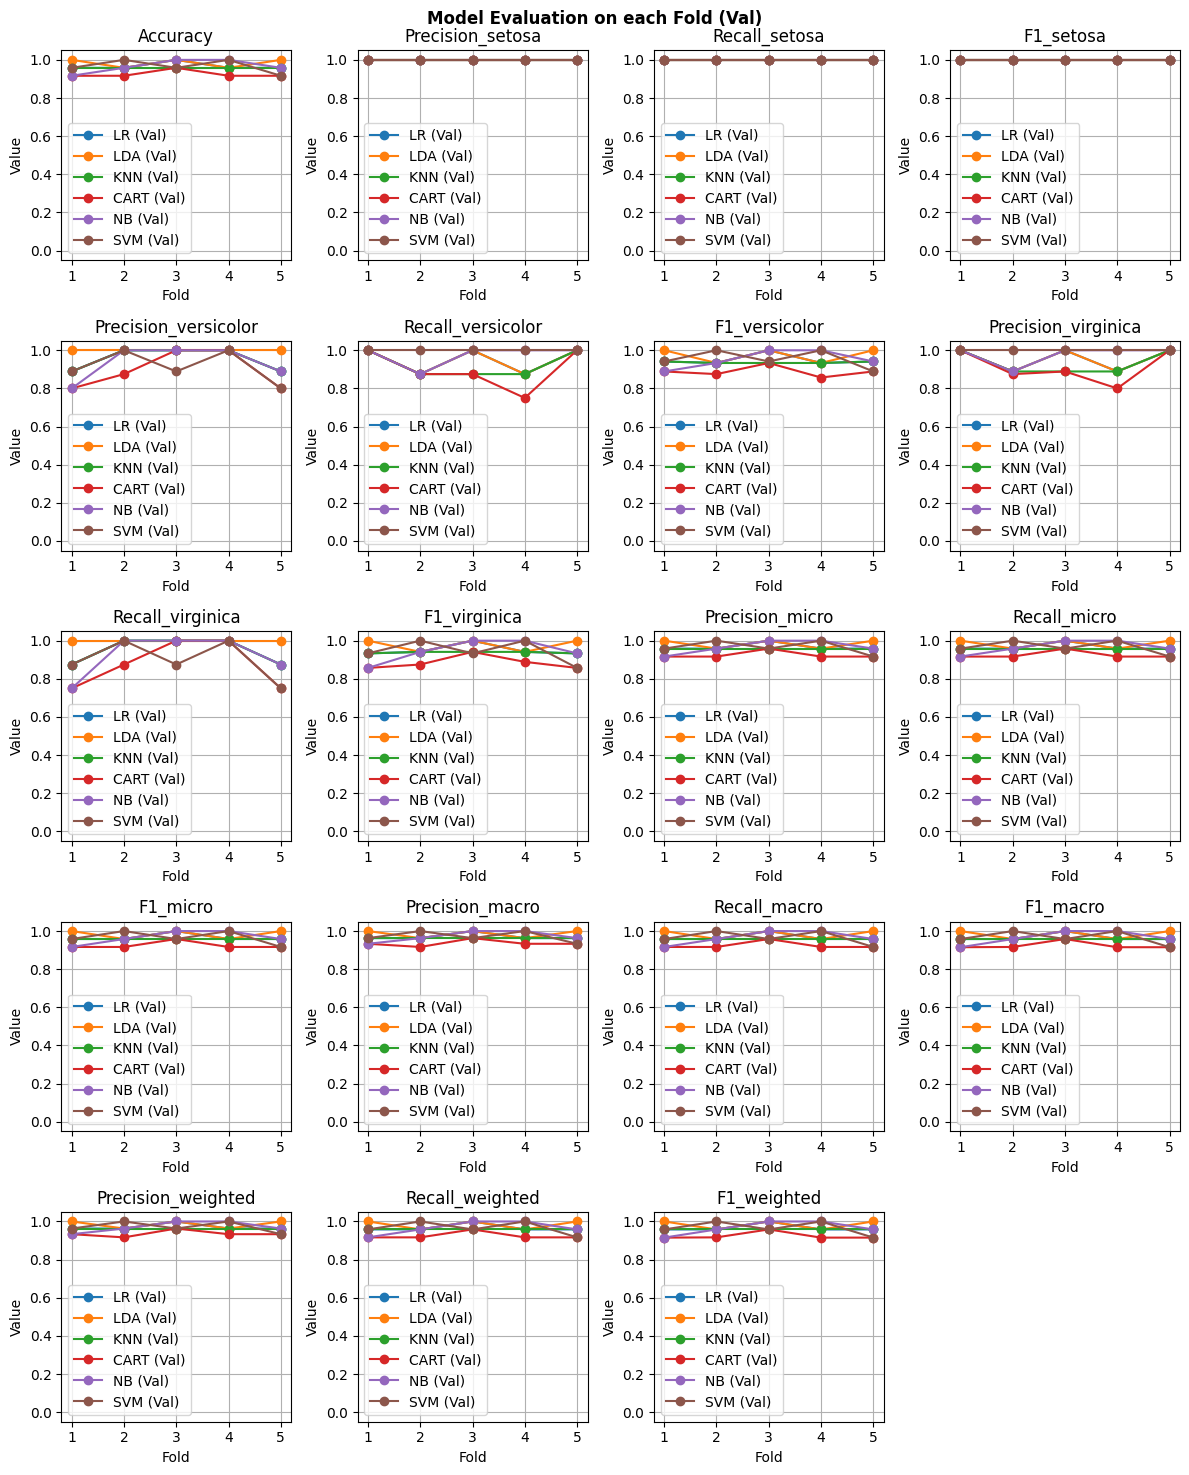

In [78]:
fig, ax = plt.subplots(5, 4, figsize=(12, 15))
ax = ax.flatten()
ax[-1].remove()
for i, col in enumerate(all_metrics_val[list(models.keys())[0]].columns[2:]): 
    for name, metrics in all_metrics_val.items():
        ax[i].plot(range(1, 6), metrics[col], 'o-', label=f'{name} (Val)')
    ax[i].legend()
    ax[i].set_title(col[5:])
    ax[i].set_xlabel('Fold')
    ax[i].set_ylabel('Value')
    ax[i].set_ylim(-0.05, 1.05)
    ax[i].grid()

plt.suptitle('Model Evaluation on each Fold (Val)', fontweight='bold')
plt.tight_layout()
plt.show()

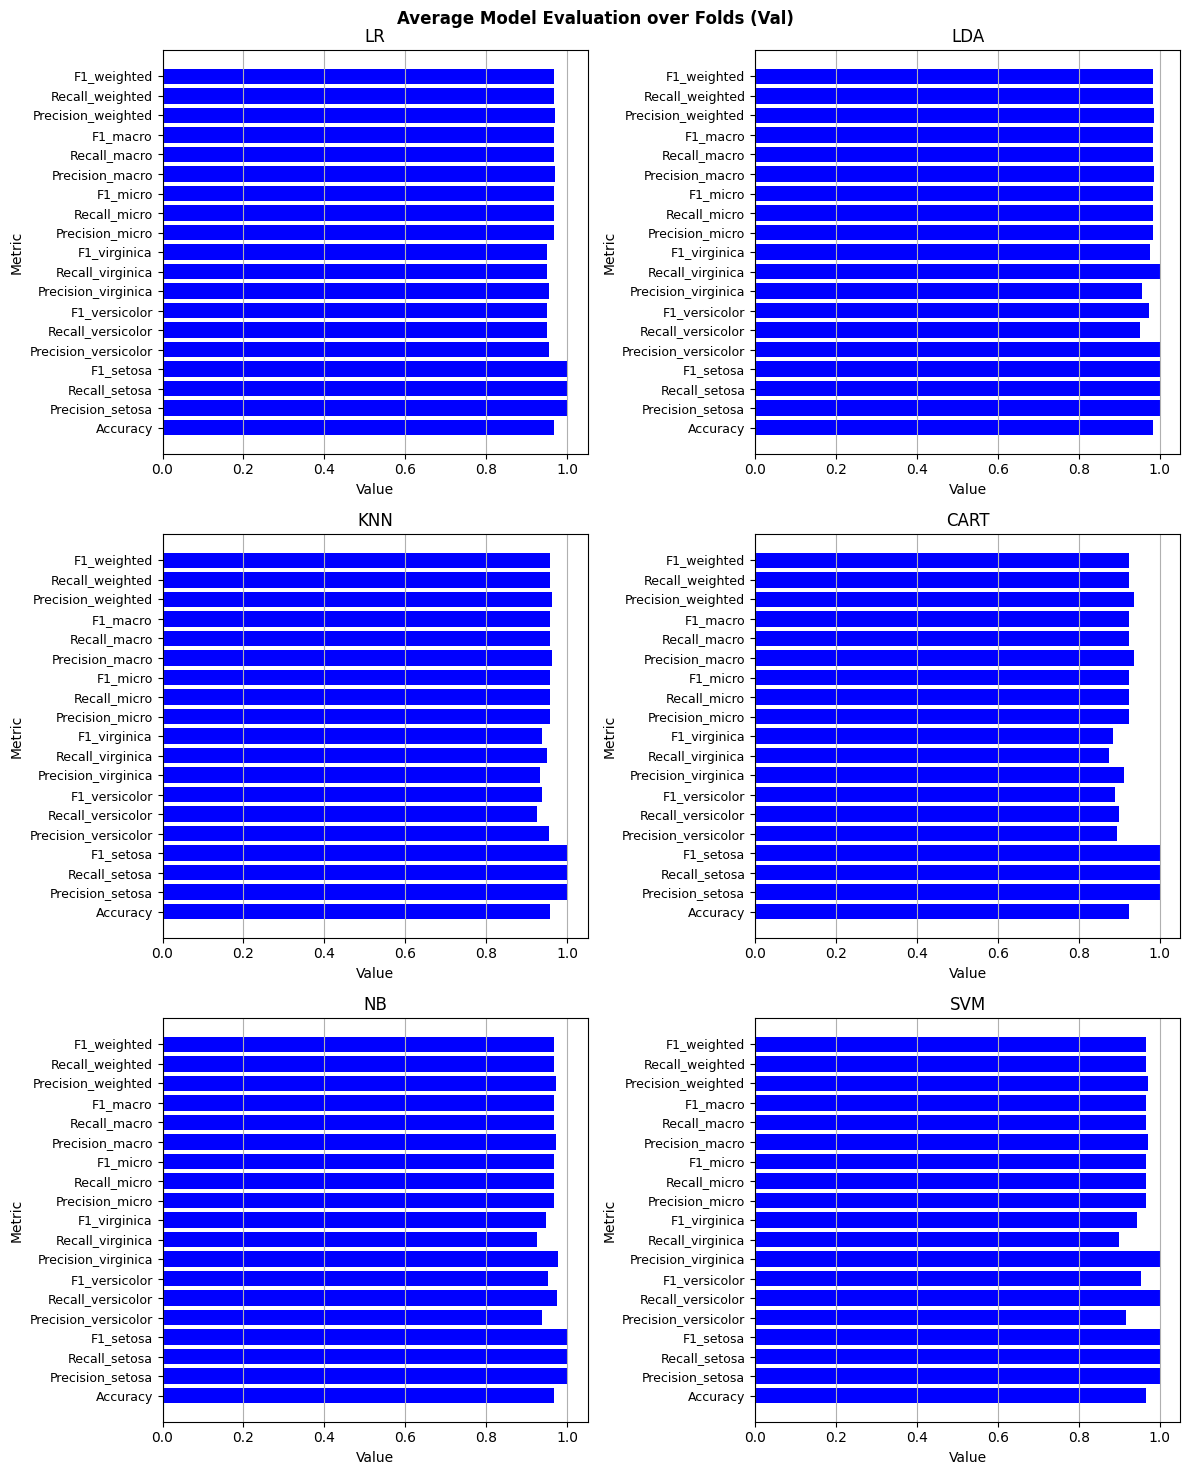

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
ax = ax.flatten()
yticklabels = [x[5:] for x in avg_metrics_val.index[2:]]

for i, col in enumerate(avg_metrics_val.columns):
    ax[i].barh(avg_metrics_val.index[2:], avg_metrics_val[col][2:], color='blue')
    ax[i].set_title(col)
    ax[i].set_yticklabels(yticklabels, fontsize=9)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Metric')
    ax[i].grid(axis='x')
    ax[i].set_xlim([0, 1.05])

plt.suptitle('Average Model Evaluation over Folds (Val)', fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3 Model Performance on Test Set

In [80]:
metrics_test = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name}:')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    metrics_test[name] = {'Accuracy': accuracy}
    for i, target in enumerate(list(iris.target_names)):
        metrics_test[name][f'Precision_{target}'] = precision[i]
        metrics_test[name][f'Recall_{target}'] = recall[i]
        metrics_test[name][f'F1_{target}'] = f1[i]

    for avg_mode in ['macro', 'micro', 'weighted']:
        metrics_test[name][f'Precision_{avg_mode}'] = precision_score(y_test, y_pred, average=avg_mode)
        metrics_test[name][f'Recall_{avg_mode}'] = recall_score(y_test, y_pred, average=avg_mode)
        metrics_test[name][f'F1_{avg_mode}'] = f1_score(y_test, y_pred, average=avg_mode)

LR:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


LDA:
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


KNN:
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  

In [81]:
metrics_test = pd.DataFrame(metrics_test)
metrics_test

,LR,LDA,KNN,CART,NB,SVM
Accuracy,0.966667,0.966667,0.966667,0.966667,0.900000,0.933333
Precision_setosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Recall_setosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
F1_setosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Precision_versicolor,1.000000,0.909091,0.909091,1.000000,0.888889,0.900000
Recall_versicolor,0.900000,1.000000,1.000000,0.900000,0.800000,0.900000
F1_versicolor,0.947368,0.952381,0.952381,0.947368,0.842105,0.900000
Precision_virginica,0.909091,1.000000,1.000000,0.909091,0.818182,0.900000
Recall_virginica,1.000000,0.900000,0.900000,1.000000,0.900000,0.900000
F1_virginica,0.952381,0.947368,0.947368,0.952381,0.857143,0.900000


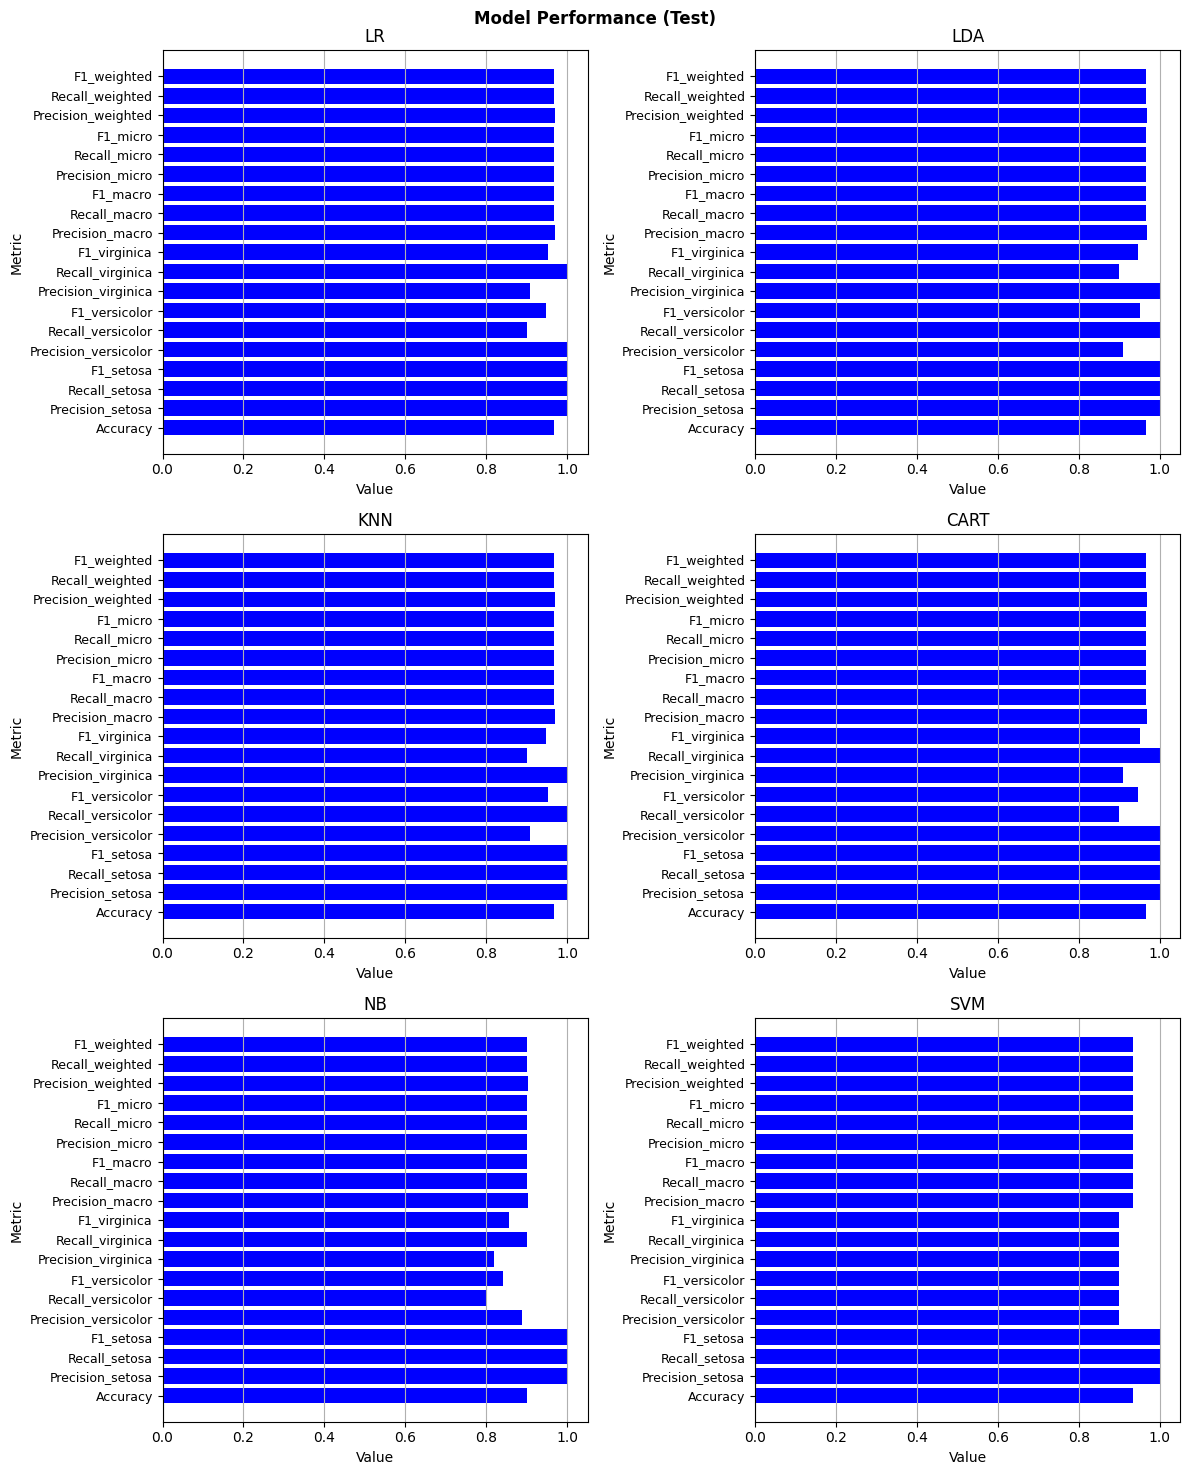

In [82]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
ax = ax.flatten()
yticklabels = [x for x in metrics_test.index]

for i, col in enumerate(metrics_test.columns):
    ax[i].barh(metrics_test.index, metrics_test[col], color='blue')
    ax[i].set_title(col)
    ax[i].set_yticklabels(yticklabels, fontsize=9)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Metric')
    ax[i].grid(axis='x')
    ax[i].set_xlim([0, 1.05])

plt.suptitle('Model Performance (Test)', fontweight='bold')
plt.tight_layout()
plt.show()

In [83]:
# avg_metrics_val.to_csv('avg_metrics_val.csv', header=True, index=True)

In [84]:
# metrics_test.to_csv('metrics_test.csv', header=True, index=True)